In [1]:
from sqlalchemy import create_engine
import os
import pandas as pd
import matplotlib.pyplot as plt

# use internal hostname if running inside a container,
# otherwise fall back to localhost
host = os.getenv("DB_HOST", "localhost")   # you can export DB_HOST=localhost/db etc.

engine = create_engine(f"postgresql://postgres:postgres@{host}:5432/pathfinder")

# -- query last 12 months of data
sql = """
SELECT
    month_start::date         AS month,
    SUM(events)      AS events,
    SUM(fatalities)  AS fatalities
FROM   acled_monthly_raw
WHERE  month_start >= (date_trunc('month', CURRENT_DATE) - interval '11 months')
GROUP  BY month
ORDER  BY month;
"""

df = pd.read_sql(sql, engine)



In [2]:


def read(sql: str, **kw):
    """Run a query and return a DataFrame (plus print the row-count)."""
    df = pd.read_sql(sql, engine, **kw)
    print(f"{len(df):,} rows")
    return df


,events,fatalities
month,,
2024-06-01,377.0,1269.0
2024-07-01,322.0,923.0
2024-08-01,415.0,797.0
2024-09-01,511.0,1292.0
2024-10-01,630.0,3021.0
2024-11-01,411.0,1553.0
2024-12-01,457.0,2344.0
2025-01-01,490.0,1933.0
2025-02-01,452.0,1783.0


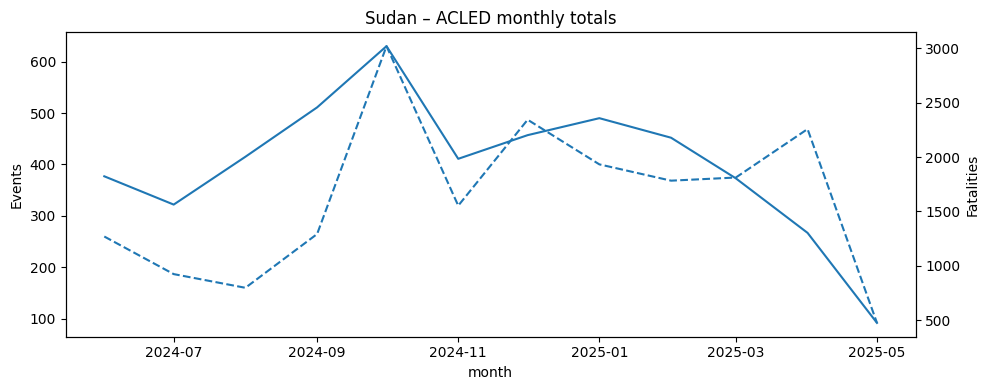

In [3]:
monthly = pd.read_sql(sql, engine).set_index("month")
display(monthly)  

# simple line chart – two y‐axes keeps the scale readable
fig, ax1 = plt.subplots(figsize=(10,4))
monthly["events"].plot(ax=ax1)
ax1.set_ylabel("Events")
ax2 = ax1.twinx()
monthly["fatalities"].plot(ax=ax2, linestyle="--")
ax2.set_ylabel("Fatalities")
plt.title("Sudan – ACLED monthly totals")
plt.tight_layout()


In [4]:
top_admin1 = read("""
    WITH recent AS (
        SELECT *
        FROM   acled_monthly_raw
        WHERE  month_start >= date_trunc('month', CURRENT_DATE) - interval '11 months'
    )
    SELECT  admin1,
            SUM(events)      AS events,
            SUM(fatalities)  AS fatalities
    FROM    recent
    GROUP   BY admin1
    ORDER   BY events DESC
    LIMIT   10;
""")

top_admin1


10 rows


,admin1,events,fatalities
0,Khartoum,1590.0,2934.0
1,North Darfur,1077.0,8765.0
2,Al Jazirah,688.0,3215.0
3,North Kordofan,238.0,909.0
4,South Darfur,215.0,552.0
5,Sennar,207.0,685.0
6,White Nile,178.0,572.0
7,West Kordofan,96.0,642.0
8,South Kordofan,87.0,417.0
9,West Darfur,71.0,184.0


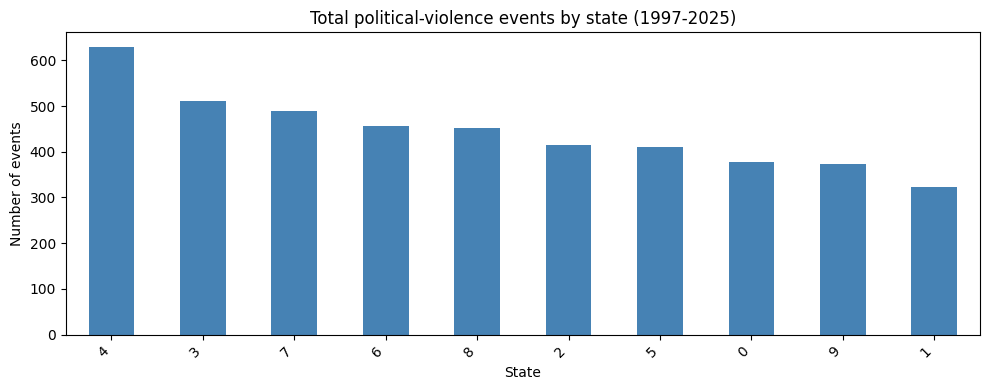

In [5]:
#Sort by events for the last 12 month

df_events = df.sort_values("events", ascending=False)

plt.figure(figsize=(10,4))
df_events["events"].head(10).plot(kind="bar", color="steelblue")
plt.xlabel("State")
plt.ylabel("Number of events")
plt.title("Total political-violence events by state (1997-2025)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [6]:
pivot = read("""
    WITH recent AS (
        SELECT *
        FROM   acled_monthly_raw
        WHERE  month_start >= date_trunc('month', CURRENT_DATE) - interval '11 months'
    )
    SELECT  month_start::date AS month,
            admin1,
            SUM(events)       AS events
    FROM    recent
    GROUP   BY month, admin1
""")

heat = (
    pivot.pivot(index="admin1", columns="month", values="events")
         .fillna(0)
         # sort columns left-to-right (oldest → newest) for readability
         .reindex(sorted(pivot["month"].unique()), axis=1)
         .astype(int)
)

heat.style.background_gradient(axis=None, cmap="Reds")


252 rows


month,2024-06-01,2024-07-01,2024-08-01,2024-09-01,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01
admin1,,,,,,,,,,,,
Abyei,2,1,2,0,2,5,6,4,2,2,3,2
Al Jazirah,67,32,48,57,142,93,82,117,26,22,2,0
Bahr el Ghazal,0,0,0,0,0,0,0,0,0,0,0,0
Blue Nile,1,2,3,2,3,5,12,4,5,12,3,1
Central Darfur,2,6,3,9,10,4,1,8,5,2,6,2
East Darfur,0,3,12,6,13,6,3,5,12,7,4,0
Equatoria,0,0,0,0,0,0,0,0,0,0,0,0
Gedaref,1,3,1,2,0,4,0,1,0,1,0,0
Kassala,0,1,1,0,0,0,1,2,5,0,3,6


273 rows


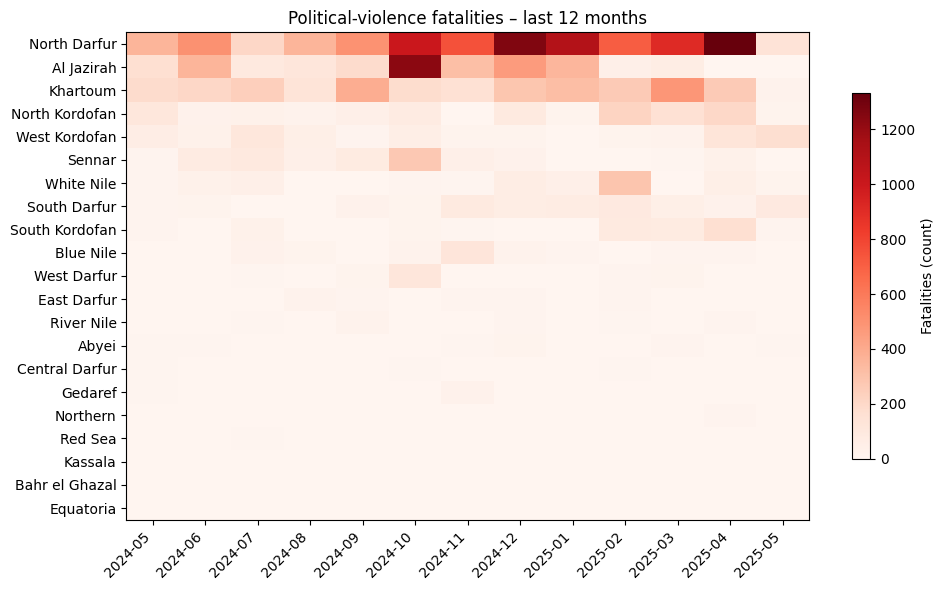

In [9]:
# ── 1. pull the data ──────────────────────────────────────────────
fatal_pivot = read(
    """
    SELECT
        month_start::date AS month,
        admin1,
        SUM(fatalities)   AS fatalities
    FROM   acled_monthly_raw
    WHERE  month_start >= (DATE_TRUNC('month', CURRENT_DATE) - INTERVAL '12 months')
    GROUP  BY month, admin1
    """,
    parse_dates=["month"]          # 👈 make pandas parse it
)
# ── 2. reshape into (admin1 × month) matrix ──────────────────────
heat_fat = (
    fatal_pivot
      .pivot(index="admin1", columns="month", values="fatalities")
      .fillna(0)
      .astype(int)
)

# order rows by total fatalities over the period
heat_fat_sorted = heat_fat.loc[
    heat_fat.sum(axis=1).sort_values(ascending=False).index
]

# ── 3. plot ───────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 6))

im = ax.imshow(
    heat_fat_sorted,
    cmap="Reds",
    interpolation="nearest",
    aspect="auto"
)

# axes & labels
ax.set_xticks(range(len(heat_fat_sorted.columns)))
ax.set_xticklabels(heat_fat_sorted.columns.strftime("%Y-%m"), rotation=45, ha="right")

ax.set_yticks(range(len(heat_fat_sorted.index)))
ax.set_yticklabels(heat_fat_sorted.index)

ax.set_title("Political-violence fatalities – last 12 months")
cbar = fig.colorbar(im, ax=ax, shrink=0.75)
cbar.set_label("Fatalities (count)")

plt.tight_layout()
plt.show()
